## Inicializacion e importe de librerias

In [9]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu


In [10]:
%pip install pydub scikit-learn wandb torchview torchviz graphviz matplotlib tqdm

In [11]:
%pip install wandb

In [12]:
!pip install torchaudio
!pip install  pydub
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
import IPython
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, confusion_matrix


import wandb
wandb.login()
%matplotlib inline


wandb: Currently logged in as: osaintnom (chicas_superpoderosas). Use `wandb login --relogin` to force relogin


bfbad9b2649155692b5f97a49a43c0eeb66dff4a

In [13]:
device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device

device(type='cpu')


# TP4: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




## BASE

In [14]:
project_name='Music_genre_classification'

### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [16]:
import os
data_dir='/content/drive/MyDrive/genres_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['rock',
 'pop',
 'hiphop',
 'disco',
 'blues',
 'reggae',
 'country',
 'metal',
 'classical',
 'jazz']

In [17]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
            fname = self.files[i]

            #img = self.transform(open_image(fpath))
            genre = parse_genres(fname)
            fpath = os.path.join(self.root,genre, fname)
            class_idx = self.classes.index(genre)
            audio = torchaudio.load(fpath)[0]

            spectogram = tt.Spectrogram(
                n_fft=1024,
            )(audio)

            # MelSpectrogram tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=512, n_mels=128)(audio)
            # mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=200, n_mels=201)(audio)

            hop_length=432
            n_mels=256
            n_fft = 2*(n_mels - 1)

            mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(audio)

            return audio,spectogram, mel_spectogram, genre_index

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        # List classes
        fmt_str += '    Classes: {}\n'.format(self.classes)
        return fmt_str
dataset = MusicDataset(data_dir)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Separamos en train y val

In [19]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [20]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
audio, spectogram, mel_spectogram, class_idx = train_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,class_idx))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 9 


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


### 3. Visualización de los archivos

In [54]:

waveform,spectogram, mel_spectogram,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))
# label = 9 es rock

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 7 


shape of spectogram torch.Size([1, 201, 552])


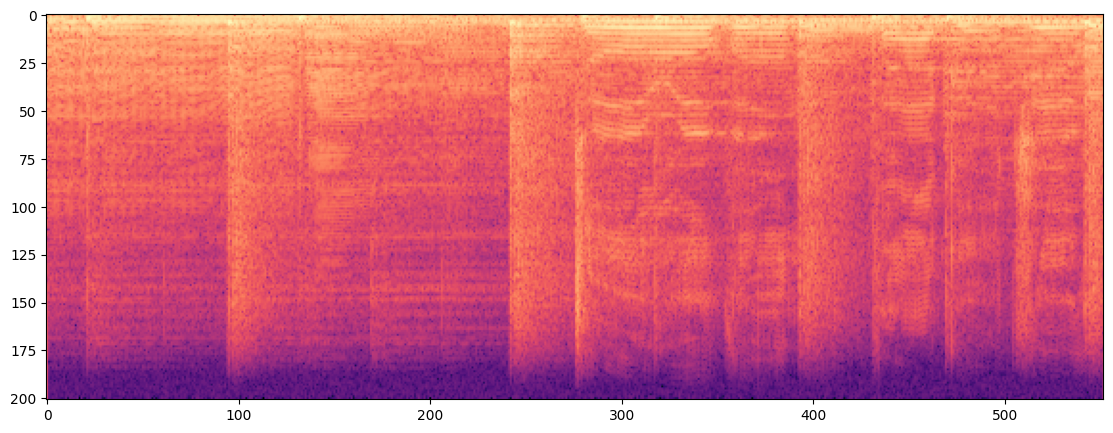

In [55]:

specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[0.1008, 0.1524, 0.1216,  ..., 0.2740, 0.2587, 0.2402]])



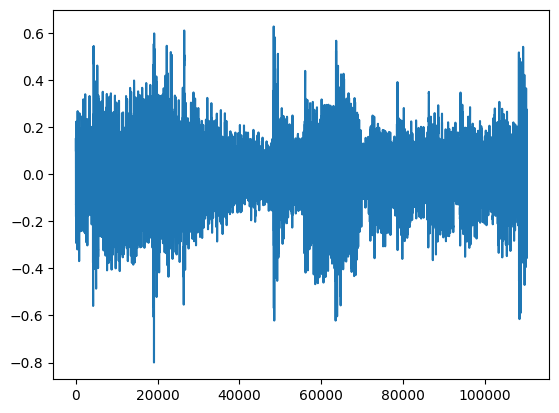

In [56]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [57]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [58]:
specgram.size()

torch.Size([1, 201, 552])

In [59]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [60]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 4. Clasificación

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)




In [ ]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cnn = M5(n_input=1, n_output=len(classes))
cnn.to(device)
print(cnn)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(cnn)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

In [ ]:
len(classes)

10

In [ ]:
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0005)
valid_losses = []
num_epochs = 30
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram
for epoch in range(num_epochs):
    losses = []

    # Train
    cnn.train()
    for wav, genre_index in train_dl:
        optimizer.zero_grad()  # Clear gradients
        wav=wav.to(device)
        genre_index =torch.as_tensor(genre_index).to(device)

        # Forward
        out = cnn(wav)
        #M5
        loss = F.nll_loss(out.squeeze(), genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    cnn.eval()
    y_true = []
    y_pred = []
    losses = []
    correct =0
    for wav, genre_index in valid_dl:
        #print(wav, genre, index)
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = cnn(wav)
        #M5
        loss = F.nll_loss(out.squeeze(), genre_index)

        losses.append(loss.item())
        #M5
        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)
        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    accuracy =correct/ len(valid_dl.dataset)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(cnn.state_dict(), 'best_model.ckpt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [1/30], Train loss: 2.1018
Epoch: [1/30], Valid loss: 2.1315, Valid accuracy: 0.2000
Saving the best model at 0 epochs!
Epoch: [2/30], Train loss: 1.8713
Epoch: [2/30], Valid loss: 1.8169, Valid accuracy: 0.3400
Saving the best model at 1 epochs!
Epoch: [3/30], Train loss: 1.7702
Epoch: [3/30], Valid loss: 1.7404, Valid accuracy: 0.4300
Saving the best model at 2 epochs!
Epoch: [4/30], Train loss: 1.6608
Epoch: [4/30], Valid loss: 1.6589, Valid accuracy: 0.4900
Saving the best model at 3 epochs!
Epoch: [5/30], Train loss: 1.6254
Epoch: [5/30], Valid loss: 1.7023, Valid accuracy: 0.4000


KeyboardInterrupt: ignored



### 5. Evaluación



In [ ]:
test_dl = DataLoader(test_ds,1,shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
# Load the best model
S = torch.load('best_model.ckpt')
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for  wav, _, spectogram, genre_index in test_dl:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = cnn(wav)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))


In [ ]:
waveform,label= test_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

In [ ]:
import IPython
IPython.display.Audio(waveform, rate=22050)

In [ ]:
wav= torch.unsqueeze(waveform, dim=0)
cnn.to(device)
wav =wav.to(device)
out = cnn(wav)
pred= out.argmax(dim=-1).flatten()
classes[pred], classes[label]

## **Ejercicio 1**

### Autoencoder

In [29]:
class Autoencoder(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super(Autoencoder, self).__init__()

        # Encoder.
        self.enc_conv1 = nn.Conv1d(n_input, n_channel, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool1d(4)
        self.enc_conv2 = nn.Conv1d(n_channel, n_channel*2, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool1d(2)
        self.enc_conv3 = nn.Conv1d(n_channel*2, n_channel*2, kernel_size=3, padding=1, stride=1)

        # Decoder.
        self.dec_conv1 = nn.ConvTranspose1d(n_channel*2, n_channel*2, kernel_size=20, stride=4, output_padding=1)
        self.dec_conv2 = nn.ConvTranspose1d(n_channel*2, n_channel, kernel_size=20, stride=2, output_padding=1)
        self.dec_conv3 = nn.ConvTranspose1d(n_channel, n_input, kernel_size=3, stride=stride, padding=1)

    def forward_encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = self.pool1(x)
        x = F.relu(self.enc_conv2(x))
        x = self.pool2(x)
        x = F.relu(self.enc_conv3(x))
        return x

    def forward_decoder(self, x):
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.dec_conv3(x))
        return x

    def forward(self, x):
        x = self.forward_encoder(x)
        x = self.forward_decoder(x)
        return x

# Assuming your audio has shape [batch_size, channels, sequence_length]
audio_size = (20, 1, 110250)  # Example shape
autoencoder = Autoencoder(n_input=audio_size[1], n_output=len(classes)).to(device)
# Dummy input for testing
dummy_input = torch.rand(audio_size).to(device)
output = autoencoder(dummy_input)
print(output.size())
print(autoencoder)

torch.Size([20, 1, 111041])
Autoencoder(
  (enc_conv1): Conv1d(1, 32, kernel_size=(3,), stride=(16,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (dec_conv1): ConvTranspose1d(64, 64, kernel_size=(20,), stride=(4,), output_padding=(1,))
  (dec_conv2): ConvTranspose1d(64, 32, kernel_size=(20,), stride=(2,), output_padding=(1,))
  (dec_conv3): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(16,), padding=(1,))
)


#### Entrenamos autoencoder

In [38]:
num_epochs = 10
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0005)
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram
valid_losses = []
for epoch in range(num_epochs):
  losses = []

  # TRAIN
  autoencoder.train()
  for data in train_dl:
      audio,spectogram, mel_spectogram, genre_index = data
      audio = audio.to(device)
      # print(audio.shape)
      genre_index =torch.as_tensor(genre_index).to(device)

      # Forward
      out = autoencoder(audio)
      # ?
      loss = loss_function(out.squeeze(), genre_index)

      # Backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      del audio #importante para ir liberando memoria ram
      del genre_index #importante para ir liberando memoria ram
      del loss #importante para ir liberando memoria ram
      del out  #importante para ir liberando memoria ram
      torch.cuda.empty_cache()  #importante para ir liberando memoria ram
      gc.collect() #importante para ir liberando memoria ram

  print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

  # VALIDATION
  autoencoder.eval()
  y_true = []
  y_pred = []
  losses = []
  correct =0
  for data in train_dl:
      audio,spectogram, mel_spectogram, genre_index = data
      audio = audio.to(device)
      # print(audio.shape)
      genre_index =torch.as_tensor(genre_index).to(device)

      # Forward
      out = autoencoder(audio)
      # ?
      loss = F.nll_loss(out.squeeze(), genre_index)

      losses.append(loss.item())
      pred= out.argmax(dim=-1).flatten()
      # append genre_index and predictions
      correct += pred.eq(genre_index).sum().item()
      y_true.extend(genre_index)
      y_pred.extend(pred)

      del audio #importante para ir liberando memoria ram
      del genre_index #importante para ir liberando memoria ram
      del loss #importante para ir liberando memoria ram
      del out  #importante para ir liberando memoria ram
      torch.cuda.empty_cache()  #importante para ir liberando memoria ram
      gc.collect() #importante para ir liberando memoria ram

  accuracy =correct/ len(valid_dl.dataset)
  valid_loss = np.mean(losses)
  print('Epoch: [%d/%d], Valid loss: %.4f' % (epoch+1, num_epochs, valid_loss))

  # Save model
  valid_losses.append(valid_loss.item())
  if np.argmin(valid_losses) == epoch:
      print('Saving the best model at %d epochs!' % epoch)
      torch.save(autoencoder.state_dict(), 'best_model.ckpt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.war

Epoch: [1/10], Train loss: 11.4327


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [1/10], Valid loss: -0.5566, Valid accuracy: 0.8400
Saving the best model at 0 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [2/10], Train loss: 11.4346


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [2/10], Valid loss: -0.5561, Valid accuracy: 0.8400


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [3/10], Train loss: 11.4336


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [3/10], Valid loss: -0.5532, Valid accuracy: 0.8400


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [4/10], Train loss: 11.4320


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [4/10], Valid loss: -0.5493, Valid accuracy: 0.8400


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [5/10], Train loss: 11.4331


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [5/10], Valid loss: -0.5459, Valid accuracy: 0.8400


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

KeyboardInterrupt: ignored

In [62]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

gc.collect() # importante para ir liberando memoria ram

val_loss = 0
val_acc = 0
train_acc = 0

lr = 0.0001

# Loss function is pixel wise
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, momentum=0.5)

train_losses = []
train_accs = []
valid_losses = []

valid_accs = []
num_epochs = 30

log = False


if log:
    wandb.init(
        project=project_name,
        name=f"{autoencoder.__class__.__name__}_lr={lr}_bs={batch_size}_epochs={num_epochs},{device}",
    )

# IPython clear cell output
# IPython.display.clear_output()

# iterator = tqdm(range(num_epochs), total=num_epochs, desc="Epoch")

for epoch in range(num_epochs):
    train_losses_itter = []

    total = 0
    train_correct = 0

    # Train
    autoencoder.train()
    for wav, _, spectogram, genre_index in train_dl:
        #print(spectogram.shape)
        optimizer.zero_grad()  # Clear gradients
        spectogram = spectogram.to(device)#.squeeze(1)
        #print(spectogram.shape)

        # Spectogram is Batched [10, 1, 256, 256]
        # Squeeze to [10, 256, 256]
        # Unsqueeze to [10, 256, 256, 1]
        #spectogram = spectogram.squeeze(1).unsqueeze(3)

        #print(spectogram.shape)
        #genre_index = torch.as_tensor(genre_index).to(device)

        # Forward
        out = autoencoder(spectogram)

        # autoencoder UNET, loss function
        loss = loss_function(out.squeeze().reshape(spectogram.shape), spectogram)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_itter.append(loss.item())

        pred = out.argmax(dim=-1).flatten()
        train_correct = 0

        total += len(pred)
        train_acc = 100 * train_correct / total

        del spectogram #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

        gc.collect() #importante para ir liberando memoria ram


        # iterator.set_postfix_str(
        #     {
        #         "Train loss": round(np.mean(train_losses_itter), 4),
        #         "Train accuracy": round(train_acc, 4),
        #         "Valid loss": round(val_loss, 4),
        #         "Valid accuracy": round(val_acc, 4),
        #     }
        # )

        train_losses.append(np.mean(train_losses_itter))
        valid_losses.append(val_loss)
        train_accs.append(train_acc)
        valid_accs.append(val_acc)

    #print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation

    autoencoder.eval()

    y_true = []
    y_pred = []
    val_losses_itter = []

    correct = 0

    for wav, _, spectogram, genre_index in valid_dl:
        #print(wav, genre, index)
        spectogram = spectogram.to(device)
        #spectogram = spectogram.squeeze(1).unsqueeze(3)

        out = autoencoder(spectogram)

        loss = loss_function(out.squeeze().reshape(spectogram.shape), spectogram)

        val_losses_itter.append(loss.item())

        pred = out.argmax(dim=-1).flatten()

        correct = 0

        del spectogram
        del genre_index
        del loss
        del out

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

        gc.collect() #importante para ir liberando memoria ram

    #accuracy = correct / len(valid_dl.dataset)
    val_acc = 100 * correct / len(valid_dl.dataset)
    val_loss = np.mean(val_losses_itter)

    #print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, val_loss, accuracy))


RuntimeError: ignored

In [ ]:
# train_iter = iter(train_dl)
# audio,spectogram, mel_spectogram, genre_index = next(train_iter)
# audio = audio.to(device)

# with torch.no_grad():
#     outputs = autoencoder(audio)
#     latent_space = autoencoder.forward_encoder(audio)

# audio = audio.cpu().numpy()
# outputs = outputs.cpu().numpy()

# num_audio = 5
# for i in range(num_audio):
#     original_image = np.transpose(audio[i], (1, 2, 0))
#     reconstructed_image = np.transpose(outputs[i], (1, 2, 0))

#     # Mostramos la imagen original.
#     plt.figure(figsize = (9, 2))
#     plt.subplot(1, 2, 1)
#     plt.imshow(original_image, interpolation = 'none')
#     plt.title('Original Image')

#     # Mostramos la imagen reconstruida.
#     plt.subplot(1, 2, 2)
#     plt.imshow(reconstructed_image, interpolation = 'none')
#     plt.title('Reconstructed Image')

#     plt.show()

#     print(latent_space[i].shape)
#     print(latent_space[i].view(1, -1))

In [46]:
# Load the best model
S = torch.load('best_model.ckpt')
autoencoder.load_state_dict(S)
print('loaded!')

# Run evaluation
autoencoder.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for audio,spectogram, mel_spectogram, genre_index in test_dl:
        audio = audio.to(device)
        genre_index = genre_index.to(device)

        out = autoencoder(audio)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f' % (epoch+1, num_epochs, valid_loss))


loaded!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.war

Epoch: [6/10], Valid loss: -0.5459, Valid accuracy: 0.0800


In [48]:
original = test_dl.dataset[12]
print(original)
audio = original[0]
idnex = original[3]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,idnex))

(tensor([[-0.0334, -0.0404, -0.0234,  ..., -0.0197, -0.0273, -0.0298]]), tensor([[[1.0886e+00, 5.4210e-01, 4.3610e-01,  ..., 3.3306e-02,
          3.0983e-01, 2.1070e+00],
         [1.6215e-01, 1.4867e+00, 1.2907e+00,  ..., 1.0230e-01,
          7.8572e-01, 9.7148e-01],
         [1.0822e-01, 6.3511e-01, 1.0029e+00,  ..., 1.4857e-01,
          6.0099e-01, 5.2966e-01],
         ...,
         [4.2608e-04, 2.7235e-08, 4.0414e-08,  ..., 9.4467e-09,
          5.4563e-08, 5.6733e-08],
         [4.1799e-04, 8.4606e-09, 5.8826e-09,  ..., 1.4332e-08,
          4.2407e-08, 1.2293e-08],
         [4.1902e-04, 8.7402e-10, 5.1436e-10,  ..., 1.1264e-08,
          4.1336e-08, 2.2004e-09]]]), tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
     

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


In [49]:
import IPython
IPython.display.Audio(audio, rate=22050)

In [50]:
audio = audio.to(device)
print(audio.shape)

out = autoencoder(audio)

torch.Size([1, 110250])


In [52]:
import IPython
IPython.display.Audio(out.detach().numpy(), rate=22050)

### UNet

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        ##print(x.shape, skip.shape)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    # def forward(self, inputs, skip):
    #     x = self.up(inputs)
    #     # Ajuste de dimensiones
    #     diffY = skip.size()[2] - x.size()[2]
    #     diffX = skip.size()[3] - x.size()[3]

    #     x = F.pad(x, [diffX // 2, diffX - diffX // 2,
    #                   diffY // 2, diffY - diffY // 2])
    #     x = torch.cat([x, skip], axis=1)
    #     x = self.conv(x)
    #     return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 16)
        self.e2 = encoder_block(16, 32)
        self.e3 = encoder_block(32, 64)
        self.e4 = encoder_block(64, 128)

        # self.e1 = encoder_block(256, 128)
        # self.e2 = encoder_block(128, 64)
        # self.e3 = encoder_block(64, 32)
        # self.e4 = encoder_block(32, 16)

        """ Bottleneck """
        #self.b = conv_block(16, 32)
        self.b = conv_block(128, 256)
        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)
        self.d4 = decoder_block(32, 16)

        # self.d1 = decoder_block(32, 64)
        # self.d2 = decoder_block(64, 128)
        # self.d3 = decoder_block(128, 256)
        # self.d4 = decoder_block(256, 512)

        """ Classifier """
        self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)

    # def encode(self, inputs):
    #     """ Encoder """
    #     #print("I", inputs.shape)
    #     s1, p1 = self.e1(inputs)
    #     #print("E1", s1.shape, p1.shape)
    #     s2, p2 = self.e2(p1)
    #     #print("E2", s2.shape, p2.shape)
    #     s3, p3 = self.e3(p2)
    #     #print("E3", s3.shape, p3.shape)
    #     s4, p4 = self.e4(p3)
    #     #print("E4", s4.shape, p4.shape)


    #     return p4, (s1, s2, s3, s4)

    # def decode(self, inputs, skips):
    #     """ Decoder """
    #     #print("D", inputs.shape, skips[3].shape)
    #     d1 = self.d1(inputs, skips[3])
    #     #print("D1", d1.shape, skips[2].shape)
    #     d2 = self.d2(d1, skips[2])
    #     #print("D2", d2.shape, skips[1].shape)
    #     d3 = self.d3(d2, skips[1])
    #     #print("D3", d3.shape, skips[0].shape)
    #     d4 = self.d4(d3, skips[0])
    #     #print("D4", d4.shape)


    #     return d4
    # def forward(self, inputs):
    #     """ Encoder """
    #     p4, (s1, s2, s3, s4) = self.encode(inputs)
    #     """ Bottleneck """
    #     b = self.b(p4)
    #     """ Decoder """
    #     d4 = self.decode(b, (s1, s2, s3, s4))
    #     """ Classifier """
    #     outputs = self.outputs(d4)
    #     # #print(outputs.shape)
    #     return outputs

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        # #print(outputs.shape)
        return outputs

model = UNet().to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 1943761


#### entrenamos y evaluamos UNet

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

gc.collect() # importante para ir liberando memoria ram

val_loss = 0
val_acc = 0
train_acc = 0

lr = 0.0001

# Loss function is pixel wise
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

train_losses = []
train_accs = []
valid_losses = []

valid_accs = []
num_epochs = 30

log = False


if log:
    wandb.init(
        project=project_name,
        name=f"{model.__class__.__name__}_lr={lr}_bs={batch_size}_epochs={num_epochs},{device}",
    )

# IPython clear cell output
# IPython.display.clear_output()

iterator = tqdm(range(num_epochs), total=num_epochs, desc="Epoch")

for epoch in iterator:
    train_losses_itter = []

    total = 0
    train_correct = 0

    # Train
    model.train()
    for wav, _, spectogram, genre_index in train_dl:
        #print(spectogram.shape)
        optimizer.zero_grad()  # Clear gradients
        spectogram = spectogram.to(device)#.squeeze(1)
        #print(spectogram.shape)

        # Spectogram is Batched [10, 1, 256, 256]
        # Squeeze to [10, 256, 256]
        # Unsqueeze to [10, 256, 256, 1]
        #spectogram = spectogram.squeeze(1).unsqueeze(3)

        #print(spectogram.shape)
        #genre_index = torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(spectogram)

        # MODEL UNET, loss function
        loss = loss_function(out.squeeze().reshape(spectogram.shape), spectogram)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_itter.append(loss.item())

        pred = out.argmax(dim=-1).flatten()
        train_correct = 0

        total += len(pred)
        train_acc = 100 * train_correct / total

        del spectogram #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

        gc.collect() #importante para ir liberando memoria ram


        iterator.set_postfix_str(
            {
                "Train loss": round(np.mean(train_losses_itter), 4),
                "Train accuracy": round(train_acc, 4),
                "Valid loss": round(val_loss, 4),
                "Valid accuracy": round(val_acc, 4),
            }
        )

        train_losses.append(np.mean(train_losses_itter))
        valid_losses.append(val_loss)
        train_accs.append(train_acc)
        valid_accs.append(val_acc)

    #print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation

    model.eval()

    y_true = []
    y_pred = []
    val_losses_itter = []

    correct = 0

    for wav, _, spectogram, genre_index in valid_dl:
        #print(wav, genre, index)
        spectogram = spectogram.to(device)
        #spectogram = spectogram.squeeze(1).unsqueeze(3)

        out = model(spectogram)

        loss = loss_function(out.squeeze().reshape(spectogram.shape), spectogram)

        val_losses_itter.append(loss.item())

        pred = out.argmax(dim=-1).flatten()

        correct = 0

        del spectogram
        del genre_index
        del loss
        del out

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

        gc.collect() #importante para ir liberando memoria ram

    #accuracy = correct / len(valid_dl.dataset)
    val_acc = 100 * correct / len(valid_dl.dataset)
    val_loss = np.mean(val_losses_itter)

    #print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, val_loss, accuracy))


    iterator.set_postfix_str(
        {
            "Train loss": round(np.mean(train_losses)),
            "Train accuracy": round(train_acc),
            "Valid loss": round(val_loss),
            "Valid accuracy": round(val_acc),
        }
    )

    if log:
        wandb.log(
            {
                "Train loss": np.mean(train_losses),
                "Train accuracy": train_acc,
                "Valid loss": val_loss,
                "Valid accuracy": val_acc,
            }
        )


if log:
    wandb.finish()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_fr

In [ ]:
waveform, spectogram, mel_spectogram, label = next(iter(train_dl))
spec = mel_spectogram.to(device)
model.eval()
out = model(spec)
out.shape


torch.Size([20, 1, 256, 256])

In [ ]:
# Waveform from mel spectogram
waveform, spectogram, mel_spectogram, label = dataset[np.random.randint(len(dataset))]

In [ ]:
spec = mel_spectogram.to(device)
model.eval()
rec_spec = model(spec).to('cpu').squeeze(0).detach()
mel_spectogram = mel_spectogram.squeeze(0).detach().cpu()
print("waveform", waveform.shape)
print("spectogram", spectogram.shape)
print("mel_spectogram", mel_spectogram.shape)

print("rec_spec", rec_spec.shape)

hop_length=432
n_mels=256
n_fft = 2*(n_mels - 1)

waveform_out = torchaudio.transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)(rec_spec)
waveform = waveform.squeeze(0)
print("waveform_out", waveform_out.shape)
print("waveform", waveform.shape)

fig, axs = plt.subplots(2, 2, figsize=(20, 5))

axs[0, 0].plot(waveform.t().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(waveform_out.t().numpy())
axs[0, 1].set_title("Reconstructed Waveform")

axs[1, 0].imshow(mel_spectogram.log2()[0,:,:].numpy(), cmap='magma')
axs[1, 0].set_title("Original Spectogram")

axs[1, 1].imshow(rec_spec.squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 1].set_title("Reconstructed Spectogram")

#IPython.display.Audio(waveform_out.squeeze(), rate=22050)

print(waveform.shape, waveform_out.shape, mel_spectogram.shape, rec_spec.shape)
IPython.display.Audio(waveform, rate=samplerate)

ValueError: ignored

In [ ]:
IPython.display.Audio(waveform_out, rate=samplerate)

NameError: ignored

In [ ]:
# Convert mel_spectogram to waveform
waveform, spectogram, mel_spectogram, label = dataset[np.random.randint(len(dataset))]

og_waveform = waveform

n_fft = 1024
hop_length=150
n_mels=256

f_spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)

spec = f_spec(waveform)

rec_waveform = griffin_lim(spec)

print("Waveform: {}\n".format(waveform))

fig, axs = plt.subplots(2, 2, figsize=(20, 5))

axs[0, 0].plot(waveform.t().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(rec_waveform.t().numpy())
axs[0, 1].set_title("Reconstructed Waveform")

axs[1, 0].imshow(spec.log2()[0,:,:].numpy(), cmap='magma')
axs[1, 0].set_title("Original Spectogram")

axs[1, 1].imshow(f_spec(rec_waveform).log2()[0,:,:].numpy(), cmap='magma')
axs[1, 1].set_title("Reconstructed Spectogram")

print(spec.shape)
print(waveform.shape)
print(rec_waveform.shape)

IPython.display.Audio(torch.cat([waveform, rec_waveform], axis=1), rate=22050)

In [ ]:
# Convert mel_spectogram to waveform
waveform, spectogram, mel_spectogram, label = dataset[np.random.randint(len(dataset))]

og_waveform = waveform

hop_length=432
n_mels=256
n_fft = 2*(n_mels - 1)

f_spec = torchaudio.transforms.MelSpectrogram(sample_rate=samplerate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

griffin_lim = torchaudio.transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)

spec = f_spec(waveform)

rec_waveform = griffin_lim(spec)

print("Waveform: {}\n".format(waveform))

fig, axs = plt.subplots(2, 2, figsize=(20, 5))

axs[0, 0].plot(waveform.t().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(rec_waveform.t().numpy())
axs[0, 1].set_title("Reconstructed Waveform")

axs[1, 0].imshow(spec.log2()[0,:,:].numpy(), cmap='magma')
axs[1, 0].set_title("Original Spectogram")

axs[1, 1].imshow(f_spec(rec_waveform).log2()[0,:,:].numpy(), cmap='magma')
axs[1, 1].set_title("Reconstructed Spectogram")

print(spec.shape)
print(waveform.shape)
print(rec_waveform.shape)

IPython.display.Audio(torch.cat([waveform, rec_waveform], axis=1), rate=22050)

In [ ]:
ex_spec = f_spec(og_waveform)
new_spec = f_spec(rec_waveform)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].imshow(ex_spec.log2()[0,:,:].numpy(),cmap='magma')
axs[0].set_title("Original Spectogram")

axs[1].imshow(new_spec.log2()[0,:,:].numpy(),cmap='magma')
axs[1].set_title("Reconstructed Spectogram")

ex_spec.shape